In [8]:
import numpy as np 
import scipy as sp 
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import analysis_tools_nonLin_June17 as temp_tools
import matplotlib as mpl 


mpl.rcParams.update({
    # Figure
    'figure.figsize': (3.375, 2.5),  # PRL single-column
    'figure.dpi': 300,
    'figure.autolayout': False,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.02,
    
    # Fonts
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'legend.title_fontsize': 7,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],

    # Axes
    'axes.linewidth': 0.5,
    'axes.spines.top': False,
    'axes.spines.right': False,

    # Ticks
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 2.5,
    'ytick.major.size': 2.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,

    # Lines and patches
    'lines.linewidth': 1,
    'lines.markersize': 4,

    # Legend
    'legend.frameon': False,

    # Color cycle (custom PRL-style)
    'axes.prop_cycle': mpl.cycler(color=[
    "#377eb8",  # blue
    "#e41a1c",  # red
    "#4daf4a",  # green
    "#984ea3",  # purple
    "#ff7f00",  # orange
    "#a65628",  # brown
    "#f781bf",  # pink
    "#999999",  # gray
    "#66c2a5",  # cyan-teal
    "#fc8d62",  # coral
    "#8da0cb",  # indigo
])
})
def savefig_tight(name):
    plt.savefig(name, bbox_inches='tight', pad_inches=0.05)
j0 = 0.23130038585579454
flattop_gauss_amp=0.1
a_to_J = ((2 * np.pi) / (2 * (2 * 46.8197 * 1e-3))) / (1*flattop_gauss_amp)
0.236/a_to_J

0.0007034297834491154

In [9]:
data_folder = 'rabi_tomography_data_Jun272025/'
init_states, amplitudes, column_headers, data_dict = temp_tools.read_data_generate_dict(data_folder)

Initial states: ['-x', '-y', 'e', 'f', 'x', 'y']
Amplitudes: ['0.0000703', '0.0001000', '0.0003000', '0.0005000', '0.0007193', '0.0010000', '0.0015000', '0.0050000', '0.0100000', '0.0300000']
Column Headers: {'P_f_z', 'P_e_y', 'P_g_y', 'P_f_x', 'P_f_y', 'P_g_z', 'P_g_x', 'time', 'P_e_z', 'P_e_x'}


In [10]:
# Convert amplitudes to floats if not already
amp_vals = np.array([float(a) for a in amplitudes])
J_vals = a_to_J * amp_vals

# Target J values to match
plot_Js = [1.7, 0.24, 0.17, 0.10, 0.03]

# Find closest matching amplitudes
plot_amps = []
for target_J in plot_Js:
    idx = (np.abs(J_vals - target_J)).argmin()
    plot_amps.append(amplitudes[idx])

print("plot_amps =", plot_amps)

amplitudes = plot_amps

plot_amps = ['0.0050000', '0.0007193', '0.0005000', '0.0003000', '0.0001000']


In [11]:
density_dict = {}

for state in init_states:
    density_dict[state] = {}
    for amp in amplitudes:
        df = data_dict[state][amp]['scaled']
        # time = df['time'].to_numpy()
        time, rho_2 = temp_tools.reconstruct_density_matrices_2_2_from_data_dict(df)

        # Get 3×3 GEF density matrices (EF coherence, G diagonal)
        _, rho_3 = temp_tools.get_rho_3_3_from_data_dict(df)

        # Store all in dictionary
        density_dict[state][amp] = {
            'time': time,
            'rho_2': rho_2,
            'rho_3': rho_3,
        }

In [12]:
def rho3_fidelity_from_superposition(density_dict, amp, compare_basis='x'):
    """
    Compute fidelity between the superposition state (ρ_e + ρ_f)/2 and
    a measured state (e.g. 'x', '-x', 'y', etc.) in the 3×3 GEF basis.

    Args:
        density_dict: nested dict with density_dict[state][amp]['rho_3']
        amp (str): amplitude string
        compare_basis (str): state key (e.g., 'x', '-x', 'y', etc.)

    Returns:
        time (ndarray): time values
        fidelities (ndarray): fidelity vs time between (e+f)/2 and compare_basis
    """
    rho_prep_0 = density_dict['e'][amp]['rho_3']
    rho_prep_1 = density_dict['f'][amp]['rho_3']
    
    rho_super = 0.5 * (rho_prep_0 + rho_prep_1)#

    rho_comp_0 = density_dict[compare_basis][amp]['rho_3']
    rho_comp_1 = density_dict['-'+compare_basis][amp]['rho_3']
    rho_comp = 0.5 * (rho_comp_0 + rho_comp_1)
    time = density_dict['f'][amp]['time']
    
    fidelities = np.array([
        temp_tools.fidelity(rho_super[i,:,:], rho_comp[i,:,:]) for i in range(len(time))
    ])

    return time, fidelities
def rho2_fidelity_from_superposition(density_dict, amp, compare_basis='x'):
    """
    Compute fidelity between the 2×2 EF density matrix superposition (ρ_e + ρ_f)/2
    and a single comparison state (e.g. 'x', '-x', etc.) using precomputed 'rho_2'.

    Args:
        density_dict: nested dict with [state][amp]['rho_2']
        amp (str): amplitude string
        compare_basis (str): logical axis to compare against

    Returns:
        time (ndarray): time values
        fidelities (ndarray): fidelity vs time
    """
    rho_e = density_dict['e'][amp]['rho_2']
    rho_f = density_dict['f'][amp]['rho_2']
    rho_comp_0 = density_dict[compare_basis][amp]['rho_2']
    rho_comp_1 = density_dict['-'+compare_basis][amp]['rho_2']
    rho_comp = 0.5 * (rho_comp_0 + rho_comp_1)
    rho_super = 0.5 * (rho_e + rho_f)

    time = density_dict['e'][amp]['time']
    
    fidelities = np.array([
        temp_tools.fidelity(rho_super[i], rho_comp[i])
        for i in range(len(time))
    ])

    return time, fidelities

In [13]:
compare_states = ['x', 'y']
amplitudes = sorted({amp for state in density_dict for amp in density_dict[state]})

fidelity_rho3_dict = {}

for state in compare_states:
    for amp in amplitudes:
        time, fids = rho3_fidelity_from_superposition(density_dict, amp, compare_basis=state)
        fidelity_rho3_dict[(state, amp)] = {
            'time': time,
            'fidelity': fids
        }

0.1390182006138945
0.41705460184168347
0.6950910030694725
0.9999579170157431
6.9509100306947245


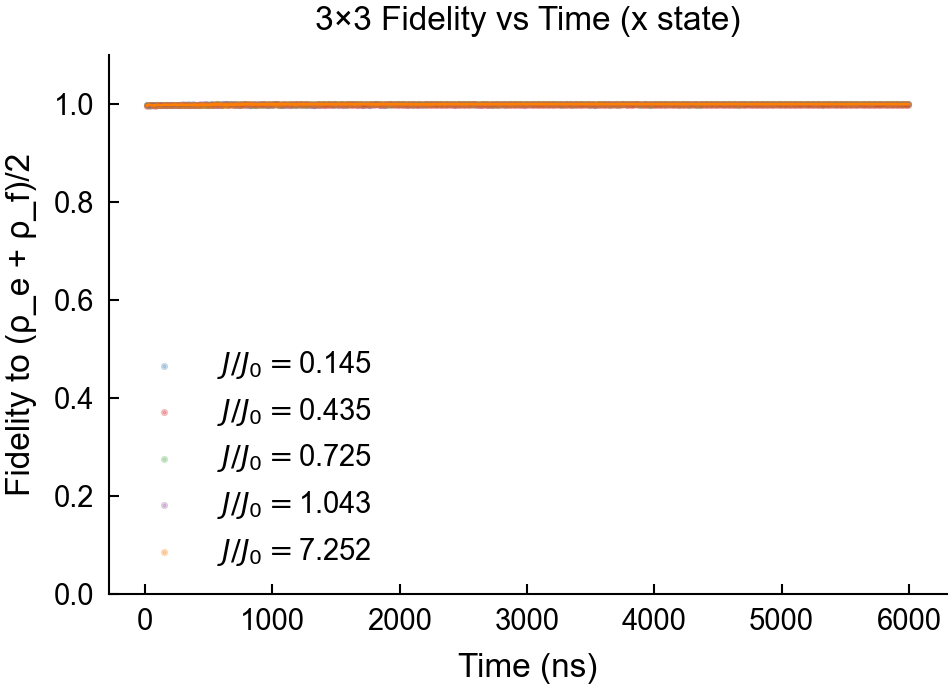

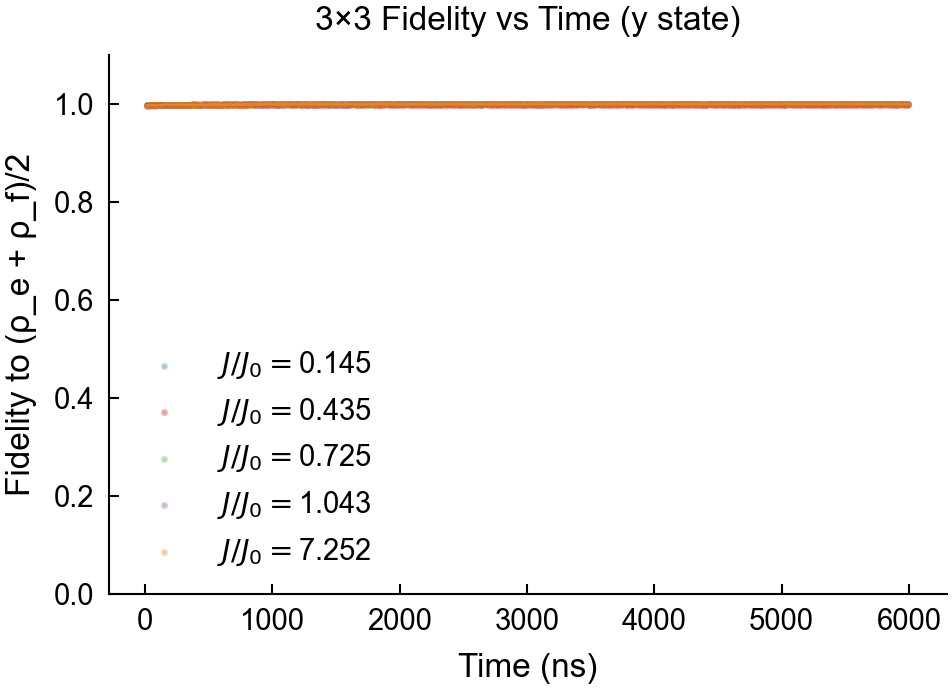

In [14]:
flattop_gauss_amp=0.1
a_to_J = ((2 * np.pi) / (2 * (2 * 46.8197 * 1e-3))) / (1*flattop_gauss_amp)
# Plot for x state
for (state, amp), data in fidelity_rho3_dict.items():
    if amp != '0.0000703':
        if state == 'x':
            label = rf'$J/J_0=${float(amp)*a_to_J/j0:.3f}'
            plt.scatter(data['time'], data['fidelity'], label=label, s=0.5, alpha = 0.3)
            plt.plot(data['time'], data['fidelity'], lw=0.7)
            print(float(amp)*a_to_J/0.24133459811273505)

plt.xlabel("Time (ns)")
plt.ylabel("Fidelity to (ρ_e + ρ_f)/2")
plt.ylim(0, 1.1)
plt.legend()
plt.title("3×3 Fidelity vs Time (x state)")
savefig_tight('Images/3x3fidelityXstate.pdf')
# plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for y state
for (state, amp), data in fidelity_rho3_dict.items():
    if amp != '0.0000703':
        if state == 'y':
            label=rf'$J/J_0=${float(amp)*a_to_J/j0:.3f}'
            plt.scatter(data['time'], data['fidelity'], label=label, s=0.5, alpha = 0.3)
            plt.plot(data['time'], data['fidelity'], lw=0.7)

plt.xlabel("Time (ns)")
plt.ylabel("Fidelity to (ρ_e + ρ_f)/2")
plt.ylim(0, 1.1)
plt.legend()
plt.title("3×3 Fidelity vs Time (y state)")
# plt.grid(True)
plt.tight_layout()
savefig_tight('Images/3x3fidelityYstate.pdf')
plt.show()



In [15]:
fidelity_rho2_dict = {}

for state in ['x', 'y']:
    for amp in amplitudes:
        time, fids = rho2_fidelity_from_superposition(density_dict, amp, compare_basis=state)
        fidelity_rho2_dict[(state, amp)] = {
            'time': time,
            'fidelity': fids
        }


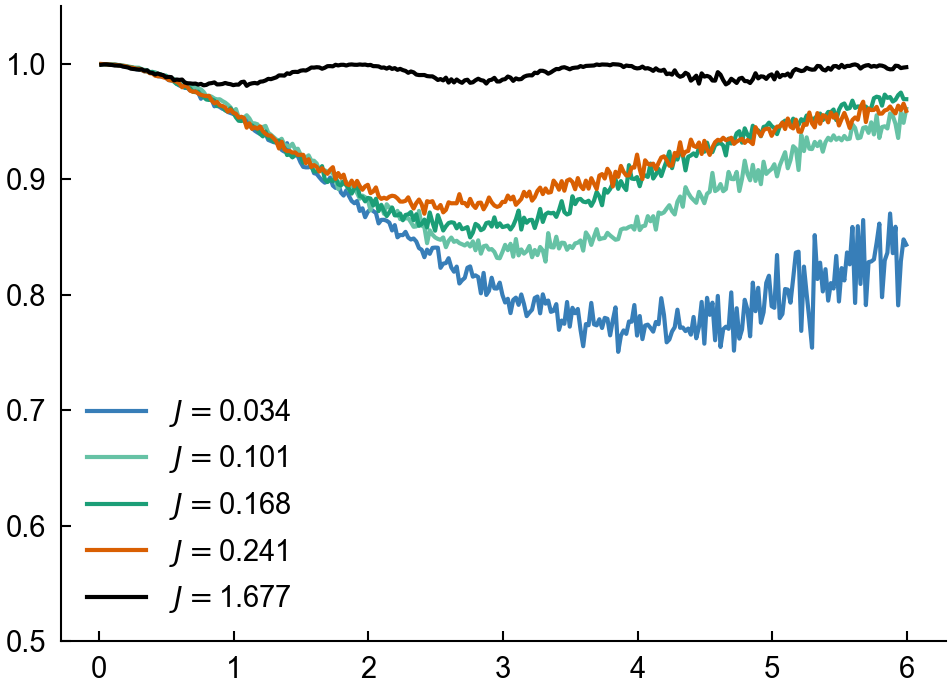

In [26]:
import pickle
with open("fidelity_vs_time_x.pkl", "rb") as f_in:
    data = pickle.load(f_in)
r_list=[0.1390182006138945,
0.41705460184168347,
0.6950910030694725,
0.9999579170157431,
1.390182006138945,
2.085273009208418,
6.9509100306947245,
13.901820061389449]
plot_styles = {
    1.7:  {"color": "#000000", "label": r"$J=1.7$", "linestyle": "-"},
    0.24: {"color": "#d95f02", "label": r"$J=0.24$", "linestyle": "-"},
    0.17: {"color": "#1b9e77", "label": r"$J=0.17$", "linestyle": "-"},
    0.10: {"color": "#66c2a5", "label": r"$J=0.10$", "linestyle": "-"},
    0.03: {"color": "#377eb8", "label": r"$J=0.03$", "linestyle": "-"},
}

for r in r_list:
    pass
    #plt.plot(data[r]["time_us"], data[r]["fidelity"], lw=1, ls = 'dashed')
    
for (state, amp), data in fidelity_rho2_dict.items():
    if amp in plot_amps:
        if state == 'x':
            label=rf'$J=${float(amp)*a_to_J:.3f}'
            if np.round(float(amp)*a_to_J,2) == 1.68:
                style = plot_styles[1.7]
            else:
                style = plot_styles[np.round(float(amp)*a_to_J,2)]
            plt.plot(data['time']/1000, data['fidelity'], label=label, color = style['color'])
            # plt.plot(data['time']/1000, data['fidelity'], lw=0.7)


plt.ylim(0.5, 1.05)
plt.legend(loc='lower left')
# plt.grid(True)
plt.tight_layout()
savefig_tight('Images/2x2fidelityXstate.pdf')
plt.show()



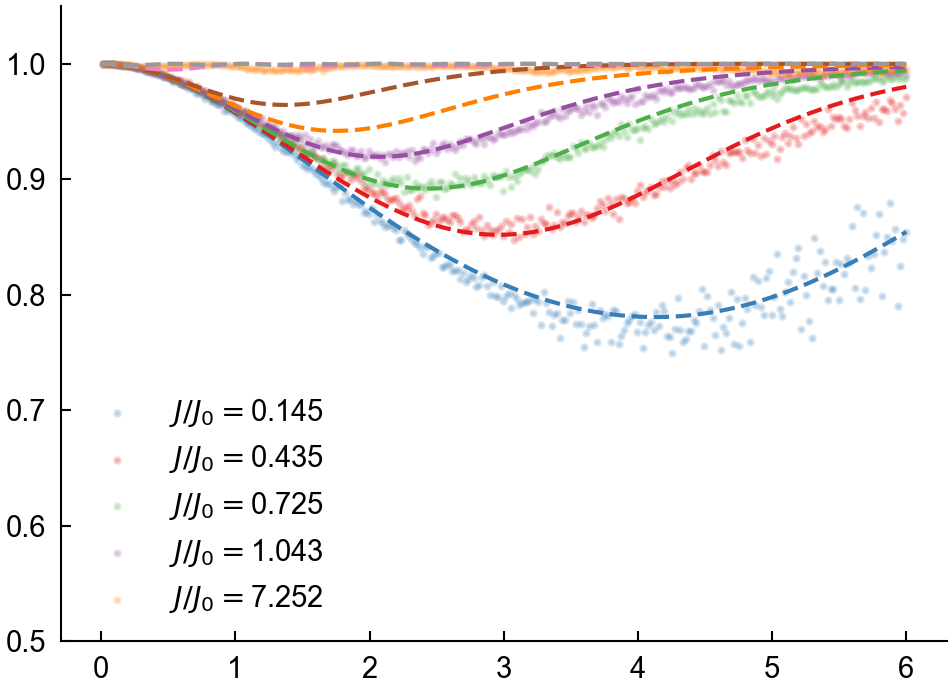

In [17]:
with open("fidelity_vs_time_y.pkl", "rb") as f_in:
    data = pickle.load(f_in)
r_list=[0.1390182006138945,
0.41705460184168347,
0.6950910030694725,
0.9999579170157431,
1.390182006138945,
2.085273009208418,
6.9509100306947245,
13.901820061389449]
for r in r_list:

    plt.plot(data[r]["time_us"], data[r]["fidelity"], lw=1, ls = 'dashed')
for (state, amp), data in fidelity_rho2_dict.items():
    if amp != '0.0000703':
        if state == 'y':
            label=rf'$J/J_0=${float(amp)*a_to_J/j0:.3f}'
            plt.scatter(data['time']/1000, data['fidelity'], label=label, s=1, alpha = 0.2)
        # plt.plot(data['time']/1000, data['fidelity'], lw=0.7)


plt.ylim(0.5, 1.05)
plt.legend(loc='lower left')
# plt.grid(True)
plt.tight_layout()
savefig_tight('Images/2x2fidelityYstate.pdf')
plt.show()
